# Modeling
### Alex Bass
### 8 Aug 2022  

*Description*: I have already tested out a few models in my previous notebook, but I wanted to redo some and try out the negative binomial regression model. I think it may be more straight forward to interpret and could still work with the imbalance of zeros

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import os
import bambi as bmb

from formulae import design_matrices

In [2]:
data = pd.read_csv('/Users/alex/Library/CloudStorage/OneDrive-Personal/DS6040/Project - School Shootings/Finalized_Data/new_train.csv') #reading in final data
data.columns

Index(['X', 'STATE', 'gun_own', 'hunt_license', 'background_checks',
       'gun_permit_law', 'COUNTY', 'under40', 'Male', 'White', 'Black',
       'Asian', 'Hispanic', 'State', 'CountyName', 'countyFIPS',
       'Unemployment_rate_2021', 'Median_Household_Income_2020', 'ba_plus',
       'less_than_hs', 'hs', 'some_col', 'population', 'n', 'gun_strictness',
       'rural', 'suburban', 'urban'],
      dtype='object')

In [3]:
data.shape

(3142, 28)

In [4]:
data.dropna(inplace = True) #dropping NAs

data['state_r'] = data['STATE']
data = data.replace({'state_r': {1: 0, 2: 1, 4: 2, 5: 3, 6: 4, 8: 5, 9: 6, 10: 7, 12: 8, 13: 9, 15: 10, 16: 11, 17: 12, 18: 13, 
                           19: 14, 20: 15, 21: 16, 22: 17, 23: 18, 24: 19, 25: 20, 26: 21, 27: 22, 28: 23, 29: 24, 30: 25, 
                           31: 26, 32: 27, 33: 28, 34: 29, 35: 30, 36: 31, 37: 32, 38: 33, 39: 34, 40: 35, 41: 36, 42: 37, 
                           44: 38, 45: 39, 46: 40, 47: 41, 48: 42, 49: 43, 50: 44, 51: 45, 53: 46, 54: 47, 55: 48, 56: 49 
}})

state_r = data.state_r.values
n_state = len(data.state_r.unique())

data.state_r.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [5]:
#scaling all data
columns_to_scale = ['gun_own',
       'hunt_license', 'under40', 'Male', 'White', 'Black', 'Asian',
       'Hispanic', 'Unemployment_rate_2021', 'Median_Household_Income_2020',
       'ba_plus', 'less_than_hs', 'hs', 'some_col',
       'population', 'gun_strictness']

data[columns_to_scale] = data[columns_to_scale].apply(lambda x : (x - np.mean(x))/np.std(x))

In [6]:
fml = "n ~ gun_own + background_checks + gun_permit_law + gun_strictness + hunt_license + under40 + Male + White + Black + Asian + Hispanic + Unemployment_rate_2021 + Median_Household_Income_2020 + ba_plus + less_than_hs + hs + some_col + urban + suburban + rural + population"  # full formulae formulation

dm = design_matrices(fml, data, na_action="error")

mx_ex = dm.common.as_dataframe()
mx_en = dm.response.as_dataframe()

mx_ex

,Intercept,gun_own,background_checks,gun_permit_law,gun_strictness,hunt_license,under40,Male,White,Black,...,Unemployment_rate_2021,Median_Household_Income_2020,ba_plus,less_than_hs,hs,some_col,urban,suburban,rural,population
0,1.0,0.833042,0.0,0.0,-1.154567,-0.186645,0.397307,-0.717680,-0.495257,0.745100,...,-1.054016,0.694312,0.589642,-0.184500,-0.346835,-0.382626,1.0,0.0,0.0,-0.145751
1,1.0,0.833042,0.0,0.0,-1.154567,-0.186645,-0.419029,-0.718403,0.187723,-0.039755,...,-0.940531,0.939418,0.960109,-0.475586,-0.917436,0.061710,1.0,0.0,0.0,0.355878
2,1.0,0.833042,0.0,0.0,-1.154567,-0.186645,0.204220,1.238609,-2.151528,2.691732,...,0.591523,-1.276080,-1.134098,2.131007,0.245205,-0.690082,0.0,1.0,0.0,-0.239213
3,1.0,0.833042,0.0,0.0,-1.154567,-0.186645,0.386655,1.392354,-0.464478,0.825132,...,-0.656817,-0.449379,-1.161714,1.112068,1.511475,-1.235287,1.0,0.0,0.0,-0.246082
4,1.0,0.833042,0.0,0.0,-1.154567,-0.186645,0.074468,-0.388431,0.699984,-0.530321,...,-1.280987,-0.154428,-0.965131,0.790681,0.158194,0.638844,1.0,0.0,0.0,-0.139885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,1.0,2.206241,0.0,0.0,-2.055884,1.079379,1.234813,0.612461,0.573391,-0.549638,...,0.534781,0.901519,-0.143786,-0.823092,-0.224346,1.501087,0.0,1.0,0.0,-0.186291
3137,1.0,2.206241,0.0,0.0,-2.055884,1.079379,0.661028,0.720313,0.648044,-0.596664,...,-0.827045,2.405455,3.348400,-1.173494,-2.484783,-1.319654,0.0,0.0,1.0,-0.242875
3138,1.0,2.206241,0.0,0.0,-2.055884,1.079379,0.884406,0.190871,0.668374,-0.595385,...,0.194324,0.947039,-0.361401,-0.911429,0.505643,0.988468,0.0,0.0,1.0,-0.252580
3139,1.0,2.206241,0.0,0.0,-2.055884,1.079379,-0.643928,0.290855,0.620004,-0.608385,...,-0.373103,0.074132,0.124250,-0.729335,-0.699993,1.565122,0.0,0.0,1.0,-0.289808


## Poisson Model

In [7]:
quick_prior_change = 5

with pm.Model() as mdl_fish:

    # define priors, weakly informative Normal
    b0 = pm.Normal("Intercept", mu=0, sigma=quick_prior_change)
    b1 = pm.Normal("background_checks", mu=0, sigma=quick_prior_change)#pm.Bernoulli("background_checks", p=Bernoulli_prior)
    b2 = pm.Normal("gun_permit_law", mu=0, sigma=quick_prior_change)
    b3 = pm.Normal("under40", mu=0, sigma=quick_prior_change)
    b4 = pm.Normal("Male", mu=0, sigma=quick_prior_change)
    b5 = pm.Normal("White", mu=0, sigma=quick_prior_change)
    b6 = pm.Normal("Black", mu=0, sigma=quick_prior_change)
    b7 = pm.Normal("Asian", mu=0, sigma=quick_prior_change)
    b8 = pm.Normal("Hispanic", mu=0, sigma=quick_prior_change)
    b9 = pm.Normal("Unemployment_rate_2021", mu=0, sigma=quick_prior_change)
    b10 = pm.Normal("Median_Household_Income_2020", mu=0, sigma=quick_prior_change)
    b11 = pm.Normal("ba_plus", mu=0, sigma=quick_prior_change)
    b12 = pm.Normal("less_than_hs", mu=0, sigma=quick_prior_change)
    b13 = pm.Normal("hs", mu=0, sigma=quick_prior_change)
    b14 = pm.Normal("some_col", mu=0, sigma=quick_prior_change)
    b15 = pm.Normal("population", mu=0, sigma=quick_prior_change)
    b16 = pm.Normal("gun_strictness", mu=0, sigma=quick_prior_change)
    b17 = pm.Normal("gun_own", mu=0, sigma=quick_prior_change)
    b18 = pm.Normal("hunt_license", mu=0, sigma=quick_prior_change)
    b19 = pm.Normal("urban", mu=0, sigma=quick_prior_change)
    b20 = pm.Normal("suburban", mu=0, sigma=quick_prior_change)
    b21 = pm.Normal("rural", mu=0, sigma=quick_prior_change)

    # define linear model and exp link function
    theta = (
        b0
        + b1 * mx_ex["background_checks"].values
        + b2 * mx_ex["gun_permit_law"].values
        + b3 * mx_ex["under40"].values
        + b4 * mx_ex["Male"].values
        + b5 * mx_ex["White"].values
        + b6 * mx_ex["Black"].values
        + b7 * mx_ex["Asian"].values
        + b8 * mx_ex["Hispanic"].values
        + b9 * mx_ex["Unemployment_rate_2021"].values
        + b10 * mx_ex["Median_Household_Income_2020"].values
        + b11 * mx_ex["ba_plus"].values
        + b12 * mx_ex["less_than_hs"].values
        + b13 * mx_ex["hs"].values
        + b14 * mx_ex["some_col"].values
        + b15 * mx_ex["population"].values
        + b16 * mx_ex["gun_strictness"].values
        + b17 * mx_ex["gun_own"].values
        + b18 * mx_ex["hunt_license"].values
        + b19 * mx_ex["urban"].values
        + b20 * mx_ex["suburban"].values
        + b21 * mx_ex["rural"].values
    )

    ## Define Poisson likelihood
    y = pm.Poisson("y", mu=pm.math.exp(theta), observed=mx_en["n"].values)

In [8]:
with mdl_fish:
    trace_1 = pm.sample(1000, tune=1000, init = 'adapt_diag', target_accept = 0.90)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rural, suburban, urban, hunt_license, gun_own, gun_strictness, population, some_col, hs, less_than_hs, ba_plus, Median_Household_Income_2020, Unemployment_rate_2021, Hispanic, Asian, Black, White, Male, under40, gun_permit_law, background_checks, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 892 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (22), generating only 20 plots
  warnings.warn(


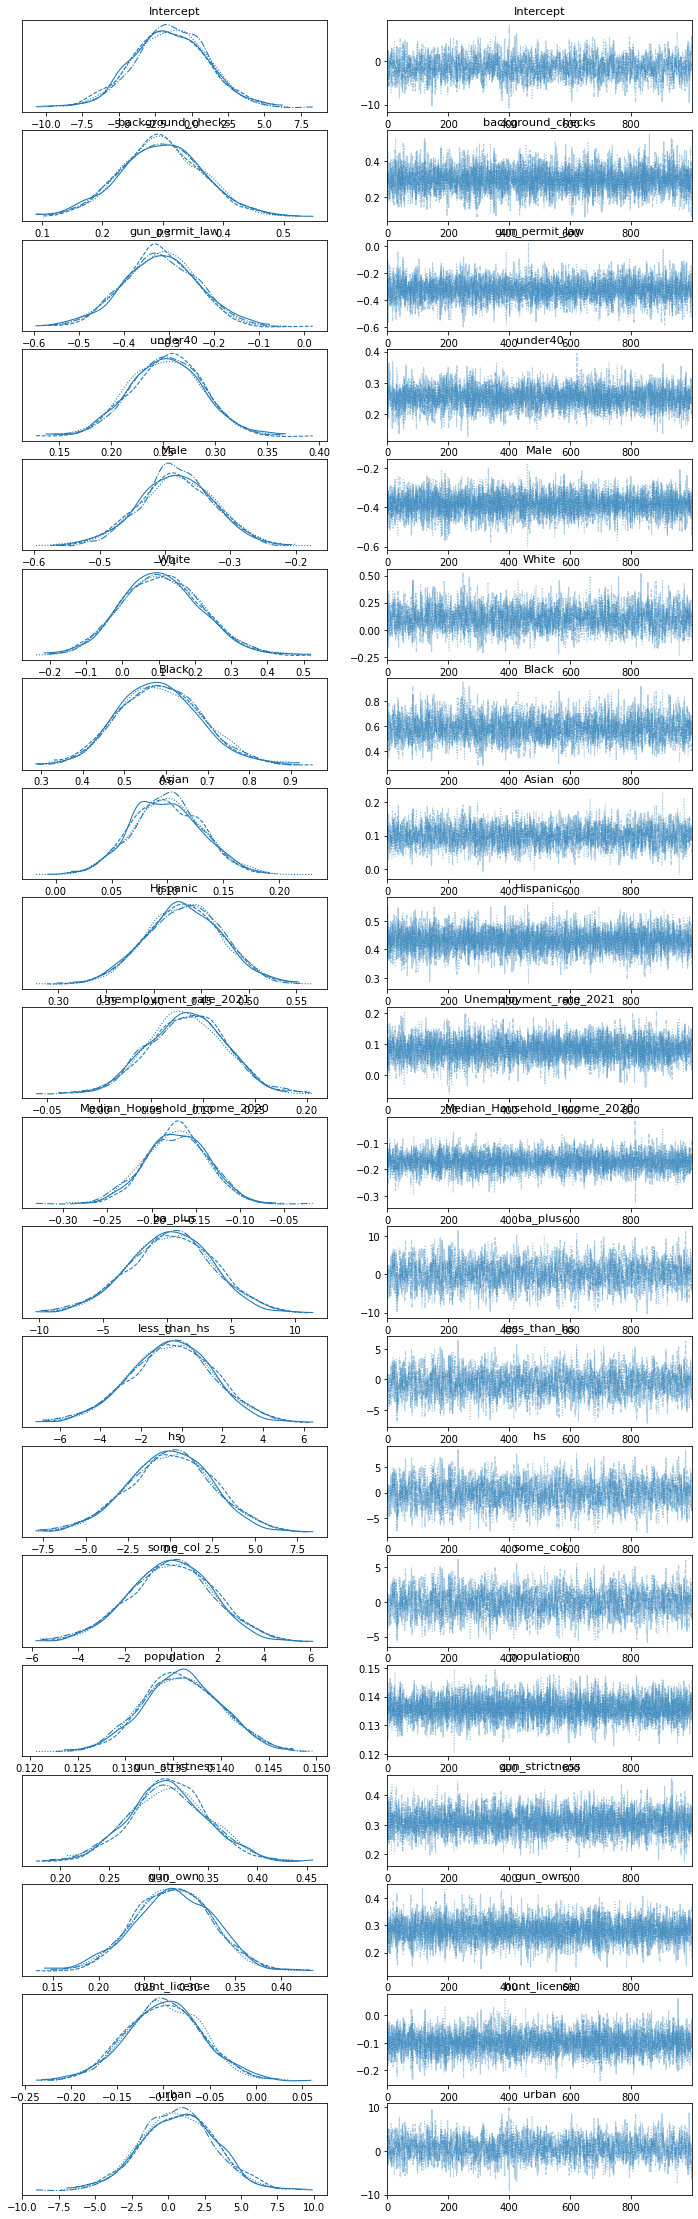

In [9]:
az.plot_trace(trace_1);

In [10]:
az.summary(trace_1, kind="stats") # these need to be exponentiated to be interpretted !!

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
Intercept,-1.464,2.503,-5.957,3.458
background_checks,0.298,0.069,0.157,0.419
gun_permit_law,-0.320,0.082,-0.472,-0.165
under40,0.253,0.035,0.185,0.315
Male,-0.383,0.058,-0.489,-0.274
White,0.110,0.111,-0.104,0.312
Black,0.586,0.098,0.405,0.771
Asian,0.100,0.032,0.039,0.156
Hispanic,0.432,0.040,0.360,0.511
Unemployment_rate_2021,0.084,0.037,0.016,0.151


## Negative Binomial

In [11]:
with pm.Model() as m_neg_binomial:
    
    #Betas
    b = pm.Normal("slopes", mu=0, sigma=5, shape=22)
    
    #Alpha
    alpha = pm.Exponential("alpha", 0.5)
    
    lambd = (
        b[21]
        + b[0] * mx_ex["gun_own"].values
        + b[1] * mx_ex["background_checks"].values
        + b[2] * mx_ex["gun_permit_law"].values
        + b[3] * mx_ex["gun_strictness"].values
        + b[4] * mx_ex["hunt_license"].values
        + b[5] * mx_ex["under40"].values
        + b[6] * mx_ex["Male"].values
        + b[7] * mx_ex["White"].values
        + b[8] * mx_ex["Black"].values
        + b[9] * mx_ex["Asian"].values
        + b[10] * mx_ex["Hispanic"].values
        + b[11] * mx_ex["Unemployment_rate_2021"].values
        + b[12] * mx_ex["Median_Household_Income_2020"].values
        + b[13] * mx_ex["ba_plus"].values
        + b[14] * mx_ex["less_than_hs"].values
        + b[15] * mx_ex["hs"].values
        + b[16] * mx_ex["some_col"].values
        + b[17] * mx_ex["urban"].values
        + b[18] * mx_ex["suburban"].values
        + b[19] * mx_ex["rural"].values
        + b[20] * mx_ex["population"].values
    )

    y = pm.NegativeBinomial("y", mu=pm.math.exp(lambd), alpha=alpha, observed=mx_en["n"])

In [12]:
with m_neg_binomial:
    trace_2 = pm.sample(1000, tune=1000, target_accept = 0.9) #, target_accept = 0.9, init='adapt_diag'

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, slopes]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 759 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'slopes'}>,
        <AxesSubplot:title={'center':'slopes'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>]], dtype=object)

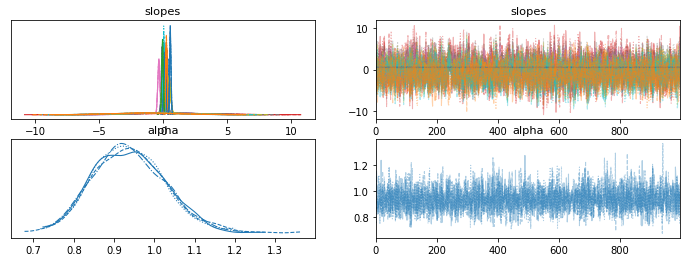

In [13]:
az.plot_trace(trace_2)

In [14]:
az.summary(trace_2, kind="stats")

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
slopes[0],0.309,0.076,0.174,0.458
slopes[1],0.446,0.118,0.238,0.672
slopes[2],-0.006,0.133,-0.265,0.232
slopes[3],0.125,0.065,0.008,0.251
slopes[4],-0.101,0.067,-0.236,0.021
slopes[5],0.232,0.057,0.129,0.338
slopes[6],-0.360,0.078,-0.511,-0.219
slopes[7],0.190,0.136,-0.071,0.439
slopes[8],0.448,0.122,0.224,0.680
slopes[9],0.035,0.053,-0.066,0.133


## Negative Binomial with Random Intercepts

In [15]:
with pm.Model() as m_neg_binomial:
    
    # Random intercepts as offsets
    b0 = pm.Normal('a', mu=0, sd=10, shape=n_state)
    
    #Betas
    b = pm.Normal("slopes", mu=0, sigma=5, shape=21)
    
    #Alpha
    alpha = pm.Exponential("alpha", 0.5)
    
    λ = pm.math.exp(
        b0[state_r]
        + b[0] * mx_ex["gun_own"].values
        + b[1] * mx_ex["background_checks"].values
        + b[2] * mx_ex["gun_permit_law"].values
        + b[3] * mx_ex["gun_strictness"].values
        + b[4] * mx_ex["hunt_license"].values
        + b[5] * mx_ex["under40"].values
        + b[6] * mx_ex["Male"].values
        + b[7] * mx_ex["White"].values
        + b[8] * mx_ex["Black"].values
        + b[9] * mx_ex["Asian"].values
        + b[10] * mx_ex["Hispanic"].values
        + b[11] * mx_ex["Unemployment_rate_2021"].values
        + b[12] * mx_ex["Median_Household_Income_2020"].values
        + b[13] * mx_ex["ba_plus"].values
        + b[14] * mx_ex["less_than_hs"].values
        + b[15] * mx_ex["hs"].values
        + b[16] * mx_ex["some_col"].values
        + b[17] * mx_ex["urban"].values
        + b[18] * mx_ex["suburban"].values
        + b[19] * mx_ex["rural"].values
        + b[20] * mx_ex["population"].values
    )

    y = pm.NegativeBinomial("y", mu=λ, alpha=alpha, observed=mx_en["n"].values)

In [16]:
with m_neg_binomial:
    trace_3 = pm.sample(1000, tune=1000, target_accept = 0.9) #, target_accept = 0.9, init='adapt_diag'

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, slopes, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1425 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'slopes'}>,
        <AxesSubplot:title={'center':'slopes'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>]], dtype=object)

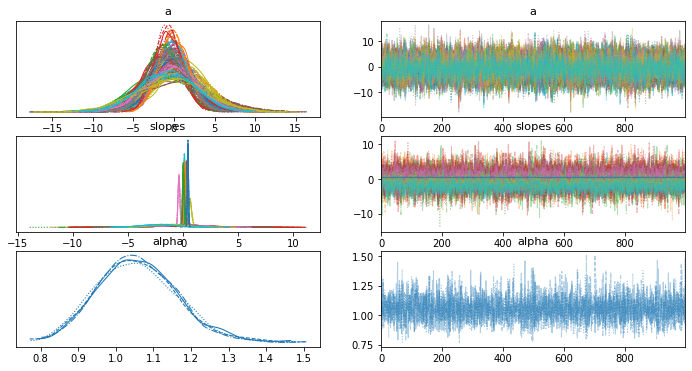

In [17]:
az.plot_trace(trace_3)

In [18]:
az.summary(trace_3, kind="stats")

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
a[0],-0.390,2.324,-4.946,3.844
a[1],0.128,3.100,-5.623,5.949
a[2],-0.542,3.785,-7.121,7.025
a[3],-0.394,2.664,-5.541,4.362
a[4],-0.566,3.029,-6.246,5.201
...,...,...,...,...
slopes[17],-0.506,1.520,-3.436,2.220
slopes[18],-1.457,1.516,-4.312,1.309
slopes[19],-2.225,1.520,-5.238,0.424
slopes[20],0.435,0.051,0.341,0.527


## Model Comparison

In [19]:
df_comp_loo = az.compare({"pooled_poisson_all": trace_1,
                          "pooled_negative_all": trace_2,
                          "Hierarchical_negative" : trace_3
                         })
df_comp_loo

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
Got error No model on context stack. trying to find log

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Hierarchical_negative,0,-2049.986704,76.384360,0.000000,0.407260,71.300400,0.000000,True,log
pooled_negative_all,1,-2051.159167,33.314842,1.172463,0.496924,76.005157,13.741069,True,log
pooled_poisson_all,2,-2596.754705,108.441902,546.768001,0.095816,195.187941,146.945750,True,log


## Predictions with Best Model

In [20]:
dir(trace_3)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_attrs',
 '_report',
 '_slice',
 '_straces',
 'add_values',
 'chains',
 'get_sampler_stats',
 'get_values',
 'nchains',
 'point',
 'points',
 'remove_values',
 'report',
 'stat_names',
 'varnames']

In [21]:
trace_3.get_values("a")[100]

array([ 0.73021666, -1.02600273,  1.2155868 ,  0.1288223 , -4.69133461,
       -4.29338058, -3.18375566, -3.88889823,  1.23763594, -1.10300016,
       -3.50181859, -2.15554728, -1.56199908,  0.97975709, -4.28059711,
       -0.08748374,  0.10523007, -0.13363396,  0.16047369, -3.51855097,
       -1.73911838, -3.42751026, -3.35008174,  0.25322737, -1.83141651,
       -2.84609406, -0.67792411,  0.88059115,  2.63753119, -1.28935049,
       -0.13827859, -4.94079094,  1.03773373, -2.44922678,  0.15868576,
        1.31585413, -6.76653678, -4.83491934, -2.82024042,  0.26358984,
       -1.0441002 , -0.06607843, -0.86773098, -0.77620178,  0.46996703,
       -1.3207193 , -4.669178  , -1.86372904, -3.67570674,  0.36706009])

In [22]:
trace_3.varnames

['a', 'slopes', 'alpha_log__', 'alpha']

In [23]:
data.shape

(3141, 29)

In [28]:
summary = az.summary(trace_3)

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [29]:
B_vector = summary[['mean']].T.reset_index(drop=True).iloc[:,:-1]
B_vector

,a[0],a[1],a[2],a[3],a[4],a[5],a[6],a[7],a[8],a[9],...,slopes[11],slopes[12],slopes[13],slopes[14],slopes[15],slopes[16],slopes[17],slopes[18],slopes[19],slopes[20]
0,-0.39,0.128,-0.542,-0.394,-0.566,-0.57,0.318,0.293,-0.106,-1.291,...,0.181,0.012,0.173,0.058,-0.167,0.144,-0.506,-1.457,-2.225,0.435


In [30]:
fml = "n ~ C(STATE) + gun_own + background_checks + gun_permit_law + gun_strictness + hunt_license + under40 + Male + White + Black + Asian + Hispanic + Unemployment_rate_2021 + Median_Household_Income_2020 + ba_plus + less_than_hs + hs + some_col + urban + suburban + rural + population"  # full formulae formulation

dm = design_matrices(fml, data, na_action="error")

X = dm.common.as_dataframe()

X

,Intercept,C(STATE)[2],C(STATE)[4],C(STATE)[5],C(STATE)[6],C(STATE)[8],C(STATE)[9],C(STATE)[10],C(STATE)[12],C(STATE)[13],...,Unemployment_rate_2021,Median_Household_Income_2020,ba_plus,less_than_hs,hs,some_col,urban,suburban,rural,population
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.054016,0.694312,0.589642,-0.184500,-0.346835,-0.382626,1.0,0.0,0.0,-0.145751
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.940531,0.939418,0.960109,-0.475586,-0.917436,0.061710,1.0,0.0,0.0,0.355878
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.591523,-1.276080,-1.134098,2.131007,0.245205,-0.690082,0.0,1.0,0.0,-0.239213
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.656817,-0.449379,-1.161714,1.112068,1.511475,-1.235287,1.0,0.0,0.0,-0.246082
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.280987,-0.154428,-0.965131,0.790681,0.158194,0.638844,1.0,0.0,0.0,-0.139885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.534781,0.901519,-0.143786,-0.823092,-0.224346,1.501087,0.0,1.0,0.0,-0.186291
3137,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.827045,2.405455,3.348400,-1.173494,-2.484783,-1.319654,0.0,0.0,1.0,-0.242875
3138,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.194324,0.947039,-0.361401,-0.911429,0.505643,0.988468,0.0,0.0,1.0,-0.252580
3139,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.373103,0.074132,0.124250,-0.729335,-0.699993,1.565122,0.0,0.0,1.0,-0.289808


In [31]:
preds = B_vector.values*X
# preds = np.array(np.exp(preds.iloc[:,:-1].sum(axis=1)[:]))
preds = np.exp(preds.iloc[:,:-1].sum(axis=1)[:])

In [32]:
preds.describe()

count    3141.000000
mean        0.245924
std         0.472939
min         0.000708
25%         0.032074
50%         0.084902
75%         0.264706
max         7.377335
dtype: float64

In [33]:
preds.sort_values(ascending=False)

2293    7.377335
1311    6.302712
1829    5.823795
50      5.339223
2505    5.249562
          ...   
538     0.002731
2269    0.002645
1758    0.002600
249     0.002529
257     0.000708
Length: 3141, dtype: float64

In [34]:
data["preds"] = preds.values
data = data[["countyFIPS","State","STATE","COUNTY","CountyName","preds"]].reset_index()

In [35]:
data.to_csv('/Users/alex/Library/CloudStorage/OneDrive-Personal/DS6040/Project - School Shootings/Finalized_Data/predicted.csv')